In [35]:
import os
from typing import List

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.io
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import PreTrainedTokenizerFast
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

In [65]:
img_test_dir = "./data/formulae/test"
img_train_dir = "./data/formulae/train"
img_val_dir = "./data/formulae/val"
equations_path = "./data/formulae/math.txt"
tokenizer_path = "./data/my_tokenizer.json"

In [ ]:
equations = []
with open(equations_path, "r") as file:
    equations = file.readlines()

tokenizer = Tokenizer(models.BPE())
tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)

trainer = trainers.BpeTrainer(special_tokens=["[PAD]", "[BOS]", "[EOS]"])
tokenizer.train_from_iterator(equations, trainer=trainer)

tokenizer.save("./data/my_tokenizer.json")

In [81]:
corrupted_img_filenames = ['0204407.png', '0204407.png', '0223644.png', '0210170.png', '0183984.png', '0207941.png', '0223460.png', '0227599.png', '0181556.png', '0161596.png', '0234659.png', '0206841.png', '0170938.png']

In [93]:
class LatexEquationDataset(Dataset):
    def __init__(self, equations_path: str, img_dir: str, tokenizer_path: str, corrupted_img_filenames: List[str] = []):
        super().__init__()
        
        with open(equations_path, "r") as file:
            self._equations = file.readlines()

        self._img_dir = img_dir
        self._img_filenames = os.listdir(img_dir)
        self._img_filenames = [x for x in self._img_filenames if x not in corrupted_img_filenames]

        self.tokenizer = PreTrainedTokenizerFast(tokenizer_file=tokenizer_path)

    def __len__(self) -> int:
        return len(self._img_filenames)
    
    def __getitem__(self, idx: int):
        img_filename = self._img_filenames[idx]
        img_idx = int(img_filename.split(".")[0])
        
        equation = self._equations[img_idx]
        token_ids = self.tokenizer.encode(equation)

        img_tensor = None
        try:
            img_tensor = torchvision.io.read_image(os.path.join(self._img_dir, img_filename))
        except:
            print(f"Failed to load {img_filename}")
        
        return img_tensor, equation, token_ids, img_filename

    def clean(self, text: str) -> str:
        strings_to_clean = ["Ġ", "Ċ", "[PAD]", "[BOS]", "[EOS]"]
        for s in strings_to_clean:
            text = text.replace(s, " ")
        return text.strip()

torch.Size([1, 64, 512])
p ( x , t ; x _ { 0 } , x _ { c } ) = { \frac { 1 } { \sqrt { 4 \pi D t } } } \left( \exp \left( - { \frac { ( x - x _ { 0 } ) ^ { 2 } } { 4 D t } } \right) - \exp \left( - { \frac { ( x - ( 2 x _ { c } - x _ { 0 } ) ) ^ { 2 } } { 4 D t } } \right) \right) ,

[81, 108, 126, 113, 148, 310, 126, 104, 102, 120, 101, 113, 126, 104, 102, 152, 101, 107, 111, 102, 103, 115, 102, 109, 101, 102, 103, 216, 102, 158, 103, 169, 224, 148, 101, 101, 101, 103, 138, 9, 103, 356, 103, 138, 9, 112, 102, 103, 115, 102, 108, 126, 112, 126, 104, 102, 120, 101, 107, 105, 102, 106, 101, 101, 102, 158, 224, 148, 101, 101, 103, 140, 10, 112, 103, 356, 103, 138, 9, 112, 102, 103, 115, 102, 108, 126, 112, 108, 106, 126, 104, 102, 152, 101, 112, 126, 104, 102, 120, 101, 107, 107, 105, 102, 106, 101, 101, 102, 158, 224, 148, 101, 101, 103, 140, 10, 103, 140, 10, 113, 99]


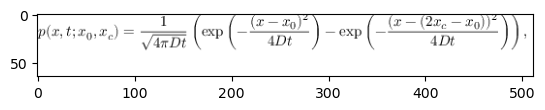

In [104]:
dataset = LatexEquationDataset(equations_path, img_train_dir, tokenizer_path, corrupted_img_filenames)
img_tensor, equation, token_ids, _ = dataset.__getitem__(11)

print(img_tensor.shape)
plt.imshow(img_tensor[0, :, :], cmap="gray")
print(equation)
print(token_ids)

In [91]:
ymax = 0
xmax = 0
for e in dataset:
    if e[0].shape[1] > ymax:
        ymax = e[0].shape[1]
    if e[0].shape[2] > xmax:
        xmax = e[0].shape[2]
print(ymax, xmax)

384 832


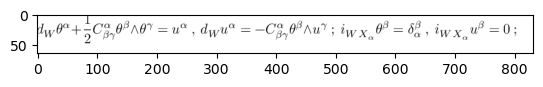

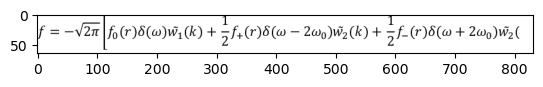

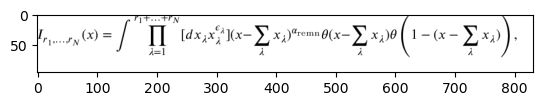

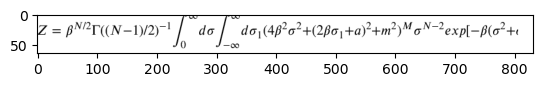

In [114]:
for e in dataset:
    if e[0].shape[2] == 832:
        plt.imshow(e[0][0, :, :], cmap="gray")
        plt.show()